# **🍊Fruit Classification | Convolutional Neural Network | Acc: 93% 📈**

## **Introduction** 👩🏻‍💻

📷🧐This model was built to enable the **InFruit** app's detecting feature. This model classifies images using **CNN architecture**. Image classification assigns a category to an image based on visual attributes using machine learning on a labeled dataset. During training, the model learns to recognize patterns within each category. The model is evaluated and fine-tuned for accuracy before being used to categorize new images. This model consists of six labels that identify apples🍎, oranges🍊, and bananas🍌 as fresh or rotten. The trained model then deployed using **TFLite**.

## **Modules** 📚

In [ ]:
# Prerequisites to TFLite Metadata Writing
!pip install tflite-support-nightly

In [ ]:
# Common Imports
import os
import zipfile
import random
import shutil
import numpy as np
from shutil import copyfile

# Data Visualization
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras Imports
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Camera Capture
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import cv2
import time

# TFLite Metadata Writing
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [ ]:
print(tf.__version__)

In [ ]:
# Upload Kaggle Cookies
files.upload()

## **Data Preprocessing** 🛠️

### **About Dataset**

🍎🍌🍊 The fruits fresh and rotten for classification dataset is a collection of **over 13,000 images** of various fruit such as Apples, Bananas, and Oranges. The images were acquired with high resolution and constant lighting to help the model extract the feature during training.

📊📉 The original dataset is split into two sets: train and test. However, the Python script provided with the dataset can be used to create the train, validation, and test sets by shuffling the images and moving them to their respective directories. Each class is also split into six caterogies, including freshapples, freshbanana, freshoranges, rottenapples, rottenbanana, and rottenoranges to ensure a consistent distribution of classes across all sets.

🌐 The full dataset can be found on this Kaggle link: [Fruits Fresh and Rotten for Classification🍏](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification)

In [ ]:
!wget --no-check-certificate -x --load-cookies cookies.txt \
  "https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification/download" \
  -O /tmp/data.zip

### **Split Dataset**

In [ ]:
# Extract zip file
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Path to the dataset folder
dataset_dir = '/tmp/dataset'

# Path to train, test, and validation folders
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

# Function to create a validation folder
def create_validation_folders():
    # Check if the validation folder already exists, if not create a new folder
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

    # List all categories
    categories = os.listdir(train_dir)

    # Loop through each category
    for category in categories:
        # Path to the category folder inside the train folder
        train_category_dir = os.path.join(train_dir, category)
        # Path to the category folder inside the test folder
        test_category_dir = os.path.join(test_dir, category)
        # Path to the category folder inside the validation folder
        validation_category_dir = os.path.join(validation_dir, category)

        # Check if the category folder already exists inside the validation folder, if not create a new folder
        if not os.path.exists(validation_category_dir):
            os.makedirs(validation_category_dir)

        # List all files in the train and test folders
        train_files = os.listdir(train_category_dir)

        # Calculate the number of files to be moved to the validation folder (10% of the total train data)
        num_validation_files = int(0.1 * len(train_files))

        # Randomly pick 10% of the files from the train folder
        validation_files_train = random.sample(train_files, num_validation_files)

        # Move files from the train folder to the validation folder
        for file in validation_files_train:
            src = os.path.join(train_category_dir, file)
            dst = os.path.join(validation_category_dir, file)
            shutil.move(src, dst)

# Call the function to create a validation folder
create_validation_folders()

### **Dataset Structure**

In [ ]:
# Path to the dataset folder
dataset_dir = '/tmp/dataset'

# Path to train, test, and validation folders
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

# Function to display the folder structure
def print_folder_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(root)))

# Print train folder's structure
print("Train Folder Structure:")
print_folder_structure(train_dir)
print()

# Print test folder's structure
print("Test Folder Structure:")
print_folder_structure(test_dir)
print()

# Print validation folder's structure
print("Validation Folder Structure:")
print_folder_structure(validation_dir)


Train Folder Structure:
train/
    freshapples/
    rottenbanana/
    rottenoranges/
    freshoranges/
    freshbanana/
    rottenapples/

Test Folder Structure:
test/
    freshapples/
    rottenbanana/
    rottenoranges/
    freshoranges/
    freshbanana/
    rottenapples/

Validation Folder Structure:
validation/
    freshapples/
    rottenbanana/
    rottenoranges/
    freshoranges/
    freshbanana/
    rottenapples/


In [ ]:
# Path to the dataset folder
dataset_dir = '/tmp/dataset'

# Path to train, test, and validation folders
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
validation_dir = os.path.join(dataset_dir, 'validation')

# Function to count the amount of data in each category folder
def count_data(directory):
    categories = os.listdir(directory)
    data_count = {}
    for category in categories:
        category_dir = os.path.join(directory, category)
        num_files = len(os.listdir(category_dir))
        data_count[category] = num_files
    return data_count

# Counts the amount of data in each category folder in the train folder
train_data_count = count_data(train_dir)
print("Train Data Count:")
print(train_data_count)
print()

# Counts the amount of data in each category folder in the test folder
test_data_count = count_data(test_dir)
print("Test Data Count:")
print(test_data_count)
print()

# Counts the amount of data in each category folder in the validation folder
validation_data_count = count_data(validation_dir)
print("Validation Data Count:")
print(validation_data_count)


Train Data Count:
{'freshapples': 1524, 'rottenbanana': 2002, 'rottenoranges': 1436, 'freshoranges': 1320, 'freshbanana': 1423, 'rottenapples': 2108}

Test Data Count:
{'freshapples': 395, 'rottenbanana': 530, 'rottenoranges': 403, 'freshoranges': 388, 'freshbanana': 381, 'rottenapples': 601}

Validation Data Count:
{'freshapples': 169, 'rottenbanana': 222, 'rottenoranges': 159, 'freshoranges': 146, 'freshbanana': 158, 'rottenapples': 234}


In [ ]:
# Function to verify the existence and contents of train, test, and validation data directories within a specified output directory
def check_split(output_dir):
    splits = ['train', 'test', 'validation']
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            print(f"{split_dir} does not exist.")
            continue

        print(f"\nChecking {split} data:")

        total_images = 0
        categories = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
            total_images += num_images
            print(f"  {category}: {num_images} images")

        print(f"Total {split} images: {total_images}")

# Path to output directory for train, test, and validation
output_dir = '/tmp/Fruits_Vegetables_Split/'

# Call the function to check the split data
check_split(output_dir)


/tmp/Fruits_Vegetables_Split/train does not exist.
/tmp/Fruits_Vegetables_Split/test does not exist.
/tmp/Fruits_Vegetables_Split/validation does not exist.


### **Data Augmentation**

In [ ]:
# Define data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Source directory for the training images
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

# Flow validation images in batches of 20 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Source directory for the validation images
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

# Flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Source directory for the test images
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

## **Model Architecture** 🏛️

### **Training Model**

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model with train_generator
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator
)

# Evaluate model with test_generator
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Found 9813 images belonging to 6 classes.
Found 1088 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Epoch 1/3
491/491 [==============================] - 110s 212ms/step - loss: 0.8066 - accuracy: 0.7084 - val_loss: 0.3872 - val_accuracy: 0.8704
Epoch 2/3
491/491 [==============================] - 100s 204ms/step - loss: 0.4122 - accuracy: 0.8499 - val_loss: 0.3798 - val_accuracy: 0.8585
Epoch 3/3
135/135 [==============================] - 15s 112ms/step - loss: 0.2359 - accuracy: 0.9122
Test accuracy: 0.9121571779251099


### **Visualization**

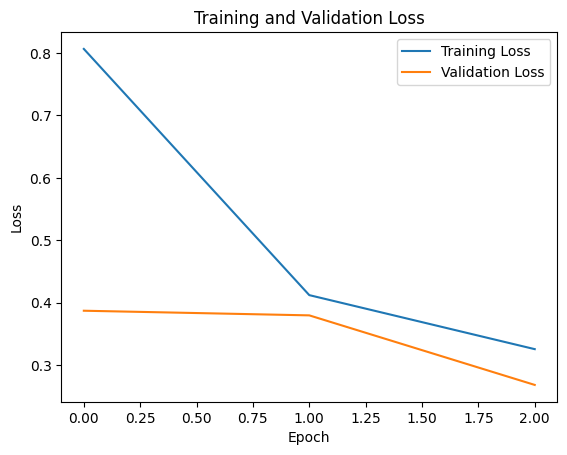

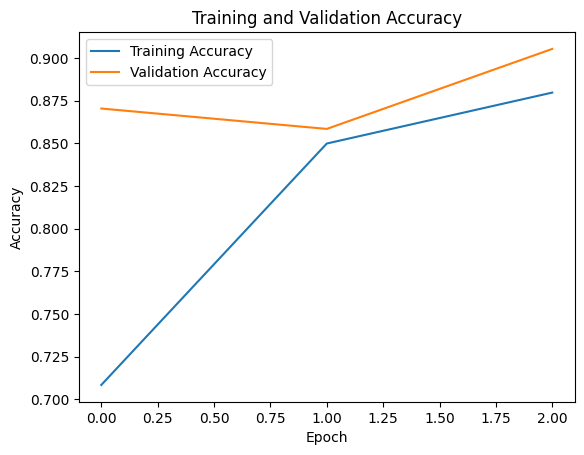

In [ ]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Evaluate Model** 🧾

In [ ]:
# Generate predictions and true labels for the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))

## **Model Predictions** 🔮

This code provided to predict image using data outside the dataset

### **With Recommendation**

1/1 [==============================] - 0s 347ms/step


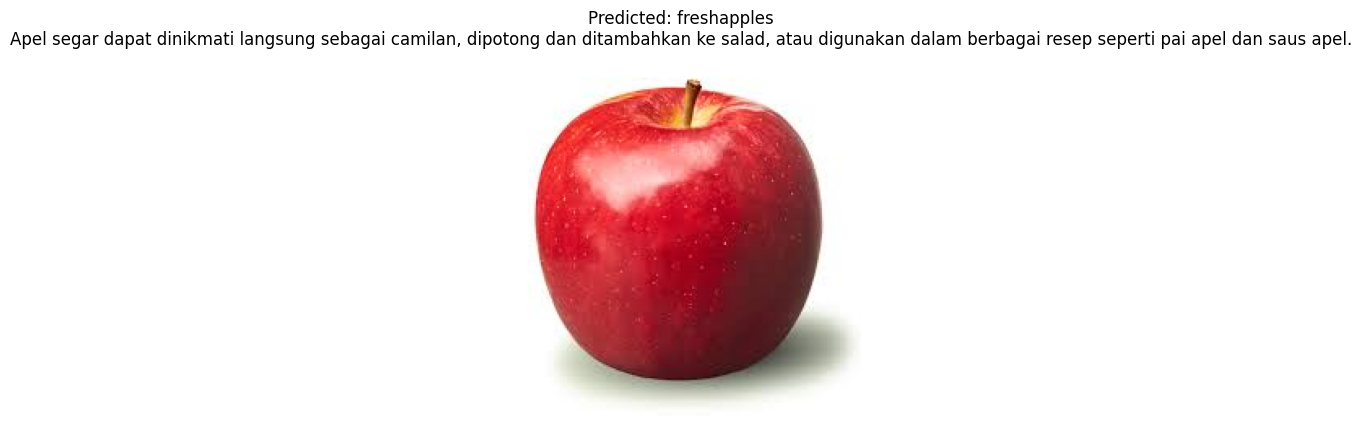

1/1 [==============================] - 0s 18ms/step


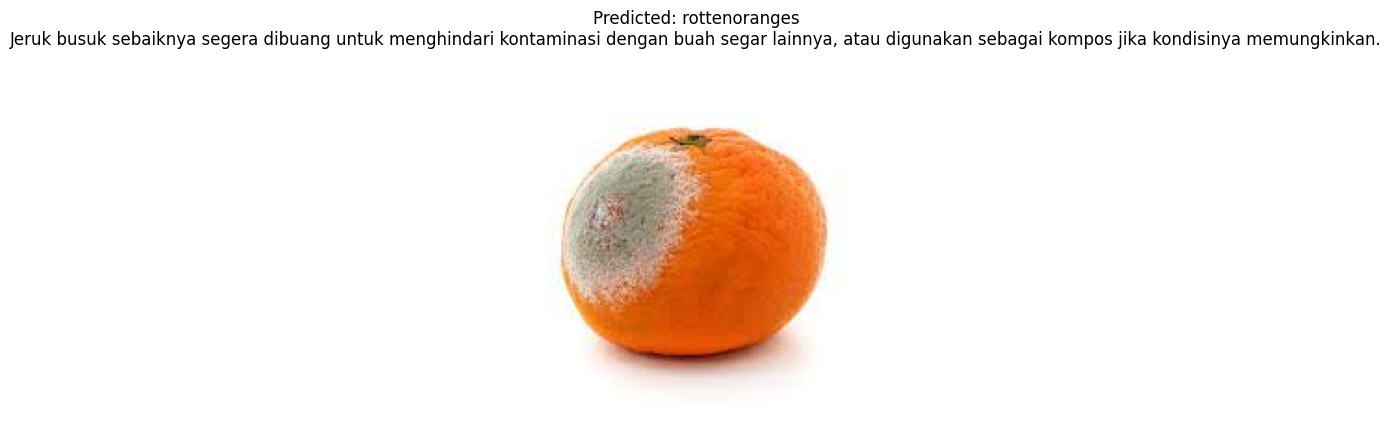

1/1 [==============================] - 0s 17ms/step


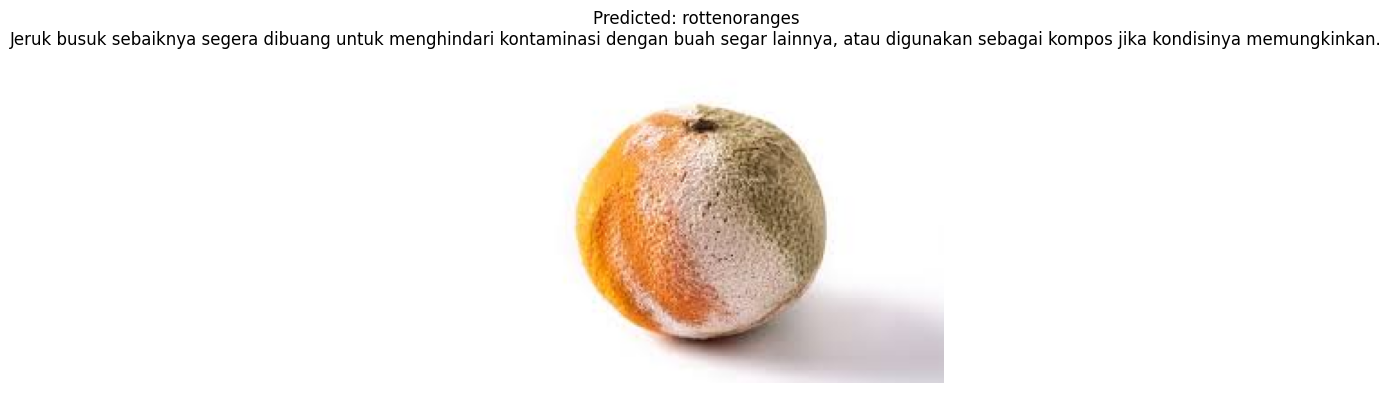

1/1 [==============================] - 0s 17ms/step


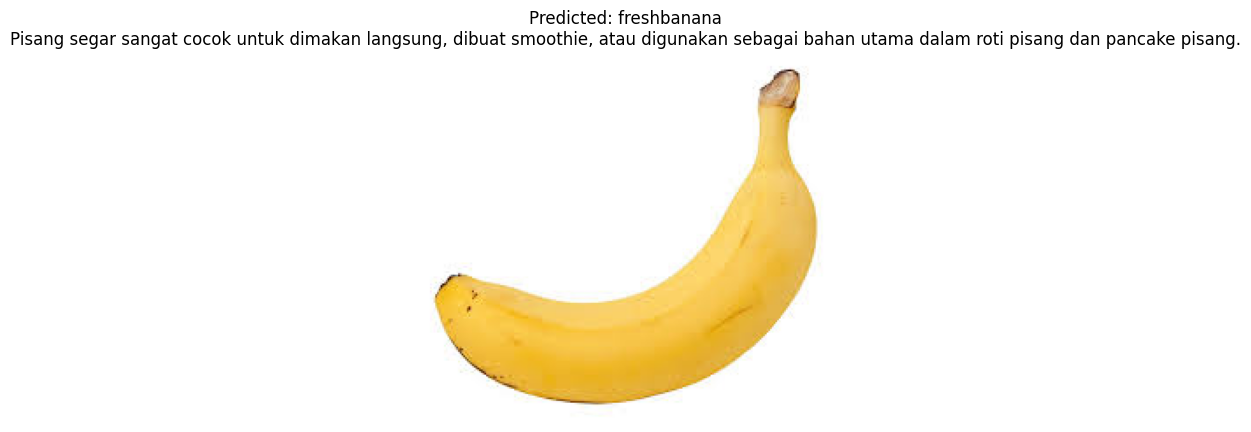

1/1 [==============================] - 0s 26ms/step


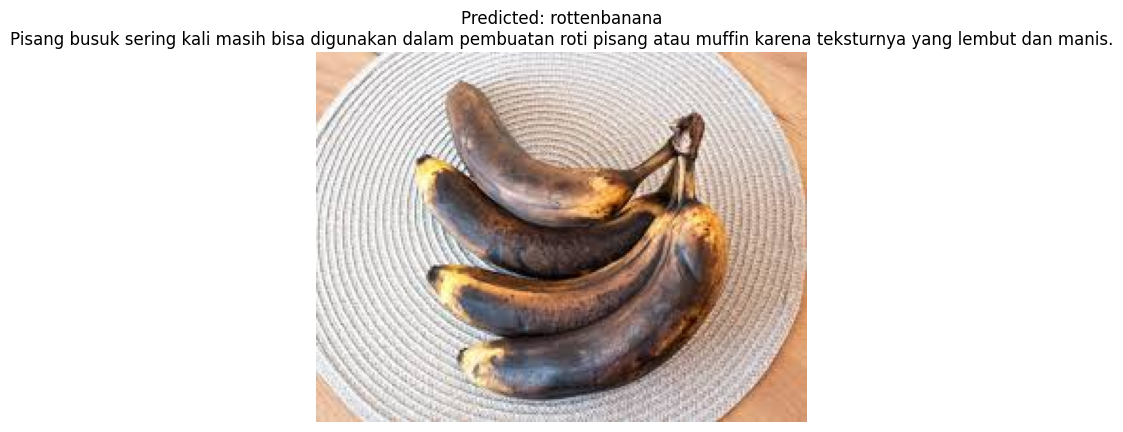

1/1 [==============================] - 0s 25ms/step


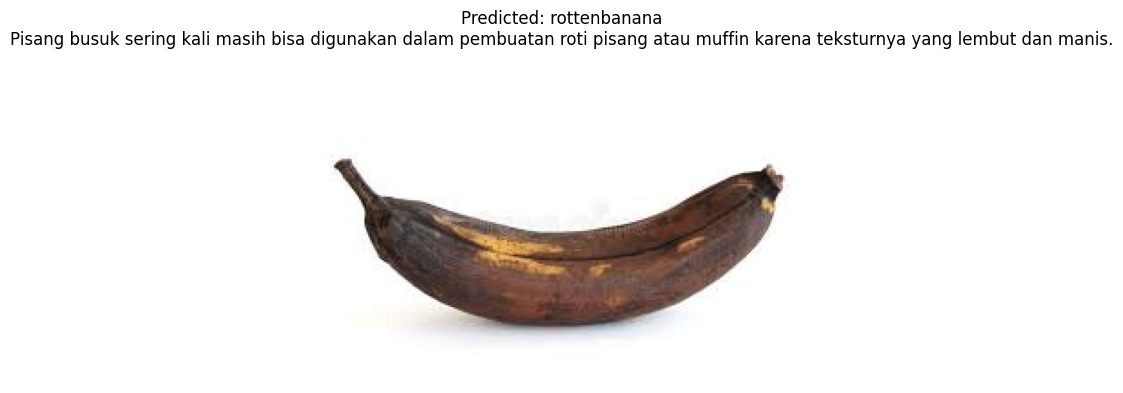

1/1 [==============================] - 0s 17ms/step


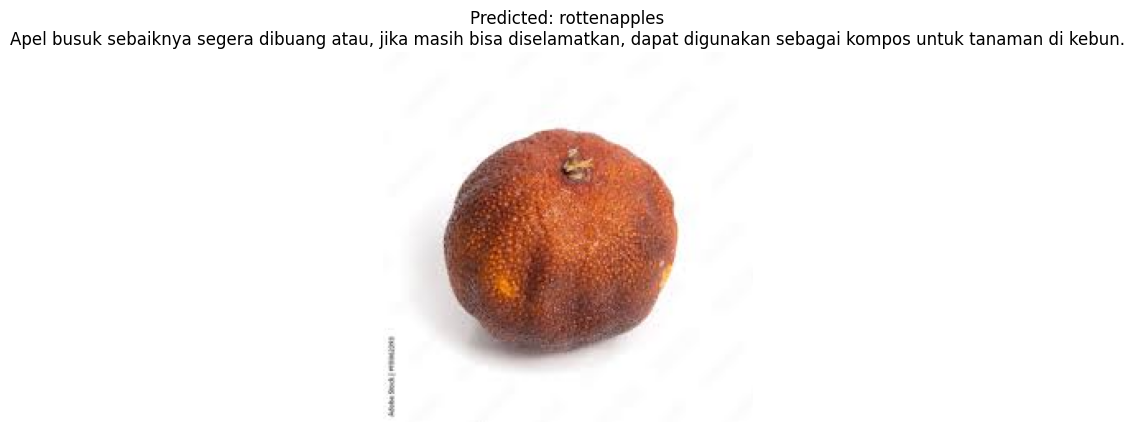

In [ ]:
# Functions for loading and processing images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimensions
    img_array /= 255.0  # Normalization
    return img_array

# Path to multiple test images
test_image_paths = [
    '/content/apple.jpg',
    '/content/orange.jpg',
    '/content/rotten_orange2.jpg',
    '/content/fresh_banana.jpg',
    '/content/rotten_banana.jpg',
    '/content/rotten_banana2.jpg',
    '/content/rotten_orange.jpg'
    # Add another test image path
]

# Category labels (must match the order used during training)
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

# Recommendations for each category
recommendations = {
    'freshapples': 'Apel segar dapat dinikmati langsung sebagai camilan, dipotong dan ditambahkan ke salad, atau digunakan dalam berbagai resep seperti pai apel dan saus apel.',
    'freshbanana': 'Pisang segar sangat cocok untuk dimakan langsung, dibuat smoothie, atau digunakan sebagai bahan utama dalam roti pisang dan pancake pisang.',
    'freshoranges': 'Jeruk segar dapat dinikmati langsung, dijadikan jus jeruk, atau ditambahkan ke salad buah untuk rasa yang segar dan manis.',
    'rottenapples': 'Apel busuk sebaiknya segera dibuang atau, jika masih bisa diselamatkan, dapat digunakan sebagai kompos untuk tanaman di kebun.',
    'rottenbanana': 'Pisang busuk sering kali masih bisa digunakan dalam pembuatan roti pisang atau muffin karena teksturnya yang lembut dan manis.',
    'rottenoranges': 'Jeruk busuk sebaiknya segera dibuang untuk menghindari kontaminasi dengan buah segar lainnya, atau digunakan sebagai kompos jika kondisinya memungkinkan.'
}

# Perform prediction on each test image
for img_path in test_image_paths:
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = categories[predicted_class[0]]

    # Display images, prediction results, and recommendations
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}\n{recommendations[predicted_label]}')
    plt.axis('off')
    plt.show()

### **Without Recommendation**

1/1 [==============================] - 0s 18ms/step


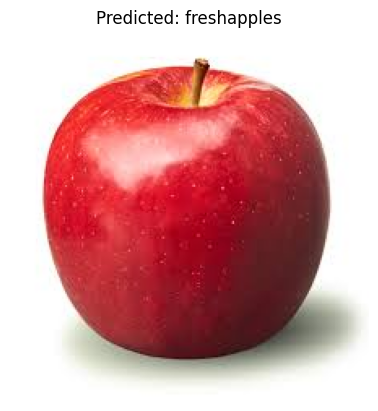

1/1 [==============================] - 0s 18ms/step


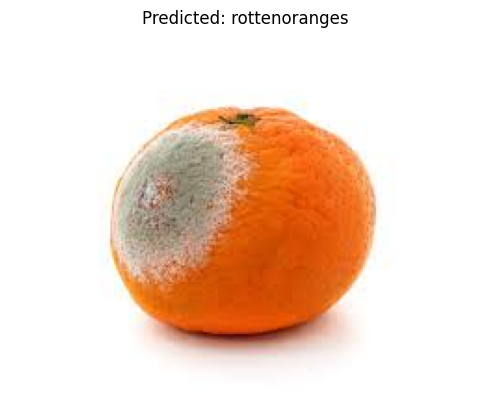

1/1 [==============================] - 0s 17ms/step


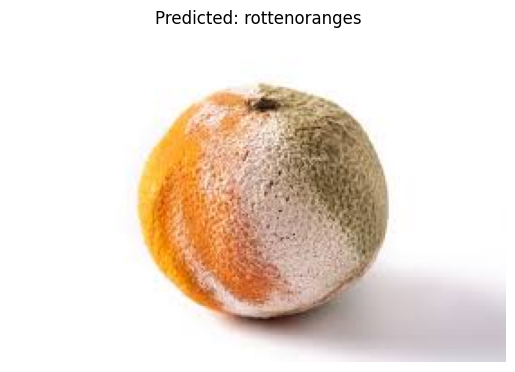

1/1 [==============================] - 0s 17ms/step


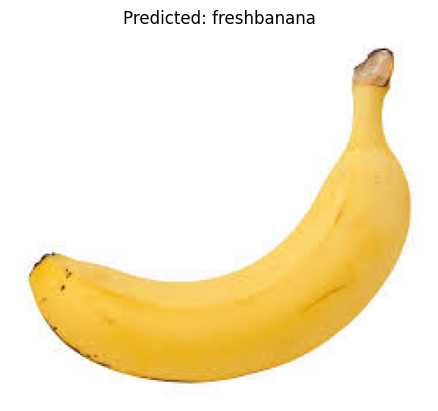

1/1 [==============================] - 0s 17ms/step


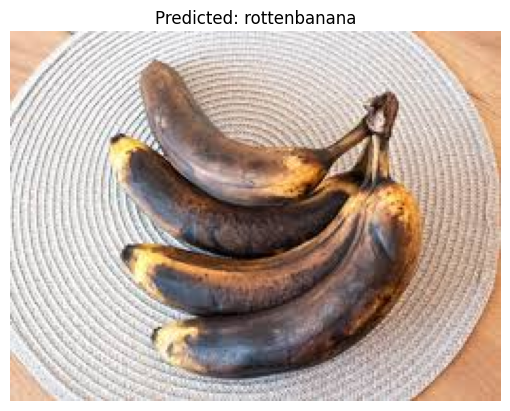

1/1 [==============================] - 0s 35ms/step


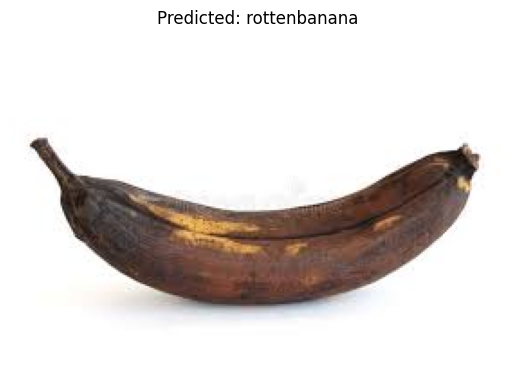

1/1 [==============================] - 0s 17ms/step


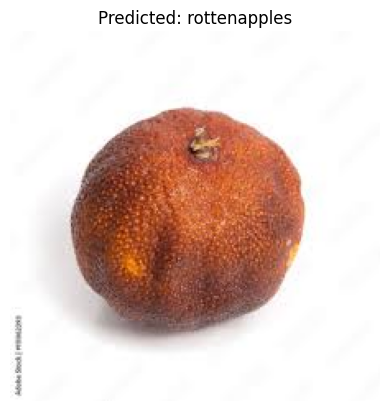

In [ ]:
# Functions for loading and processing images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimensions
    img_array /= 255.0  # Normalization
    return img_array

# Path to multiple test images
test_image_paths = [
    '/content/apple.jpg',
    '/content/orange.jpg',
    '/content/rotten_orange2.jpg',
    '/content/fresh_banana.jpg',
    '/content/rotten_banana.jpg',
    '/content/rotten_banana2.jpg',
    '/content/rotten_orange.jpg'
    # Add another test image path
]

# Category labels (must match the order used during training)
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

# Perform prediction on each test image
for img_path in test_image_paths:
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = categories[predicted_class[0]]

    # Display images and prediction results
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

## **Save the Model** 🦺

Save the model whether to **HDF5 format (.h5)** or **saved model**.



### **Save the Model** (.h5 format)

In [ ]:
# Save the model in HDF5 format
model.save('FreshAndRotten.h5')

# # If using Google Colab, use this code to download the model
# from google.colab import files

# # Download .h5 file
# files.download('FreshAndRotten.h5')

### **Save the Model** (Saved Model)

In [ ]:
# Save the model as a SavedModel
model.save('saved_model/my_model')

# Alternative way
# tf.saved_model.save(model, 'saved_model/my_model')

## **TensorFlow Lite** 🔁

### **Convert to TFLite** (if using .h5)

In [ ]:
# Load the Keras model
model = tf.keras.models.load_model('FreshAndRotten.h5')

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimization if needed
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to a file
with open('FreshAndRotten.tflite', 'wb') as f:
    f.write(tflite_model)

### **Convert to TFLite** (if using SavedModel)

In [ ]:
# Convert the SavedModel to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')

# Optionally, apply optimization
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the TFLite model to a file
with open('FreshandRotten.tflite', 'wb') as f:
    f.write(tflite_model)

### **Evaluate TFLite**

In [ ]:
# Load the test data
test_data_dir = '/tmp/dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size=(150, 150),
                                            batch_size=10,
                                            class_mode='categorical',
                                            shuffle=False)

# Initialize the TensorFlow Lite interpreter
interpreter = tf.lite.Interpreter(model_path='FreshAndRotten.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to run inference on a batch of data
def tflite_predict(interpreter, images):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    predictions = []
    for img in images:
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        predictions.append(output_data[0])
    return np.array(predictions)

# Prepare the test data
y_true = test_set.classes
predictions = []

for i in range(len(test_set)):
    x_batch, _ = test_set[i]
    x_batch = np.array(x_batch, dtype=np.float32)
    predictions.extend(tflite_predict(interpreter, x_batch))

predictions = np.array(predictions)

# Convert predictions to class labels
y_pred_binary = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)

# Calculate precision
precision = precision_score(y_true, y_pred_binary, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred_binary, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary, average='weighted')

# Print the metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Found 2698 images belonging to 6 classes.
Test Accuracy: 0.93587842846553
Precision: 0.9374322567759654
Recall: 0.93587842846553
F1 Score: 0.9357674374424025


### **TFLite Predictions**

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="FreshandRotten.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the input data
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Load an example image
image_path = '/content/rotten_banana.jpg'
input_data = preprocess_image(image_path, target_size=(150, 150))

# Compare outputs from original model and TFLite model
def compare_models(tf_model, tflite_interpreter, input_data):
    # Get prediction from original model
    tf_output = tf_model.predict(input_data)

    # Get prediction from TFLite model
    tflite_interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    tflite_interpreter.invoke()
    tflite_output = tflite_interpreter.get_tensor(output_details[0]['index'])

    return tf_output, tflite_output

# Load the original model
tf_model = tf.keras.models.load_model('saved_model/my_model')

# Compare outputs
tf_output, tflite_output = compare_models(tf_model, interpreter, input_data)
print("Original Model Output:", tf_output)
print("TFLite Model Output:", tflite_output)

1/1 [==============================] - 0s 122ms/step
Original Model Output: [[4.7811351e-14 3.3320285e-07 4.4581916e-10 3.4663253e-04 9.9962926e-01
  2.3673610e-05]]
TFLite Model Output: [[4.8896634e-14 3.4903880e-07 4.5976484e-10 3.4969585e-04 9.9962544e-01
  2.4436296e-05]]


## **Camera Capture** 🤳🏻

In [ ]:
# Function to activate the camera and get frames from the camera
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Capture the image and stop video streaming
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Load the model
model = tf.keras.models.load_model('/content/FreshAndRotten.h5')

# Define the categories
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

# Main function to capture image, predict, and display result
def predict_from_camera():
    while True:
        try:
            # Capture image from camera
            filename = take_photo()

            # Load and preprocess image
            img = Image.open(filename)
            img = img.resize((150, 150))
            img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

            # Perform prediction
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)
            predicted_label = categories[predicted_class[0]]

            # Display the image and prediction result
            display(img)
            print(f'Predicted: {predicted_label}')

            # Sleep for a while before capturing the next image
            time.sleep(1)
        except Exception as e:
            print(str(e))

# Call the main function
predict_from_camera()

## **TFLite Metadata Writing** ✍🏻

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "FreshAndRotten.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "label.txt"
_SAVE_TO_PATH = "FreshAndRotten_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 0.5 # ini ga yakin banget, soalnya kita normalisasi ke range [0,1] --> rescale(1/255.)
_INPUT_NORM_STD = 0.5 # ini ga yakin banget, soalnya kita normalisasi ke range [0,1] --> rescale(1/255.)

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)